In [69]:
import os
import pickle
import sys

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
import scipy
from Functions import renormalize, scomplex, plotting, support
import matplotlib.pyplot as plt
from scipy.stats import entropy as sp_entropy
import networkx as nx
import powerlaw as pwl

plt.rcParams["text.usetex"] = True
colors = np.array(
    [
        [0.3647, 0.2824, 0.1059],
        [0.8549, 0.6314, 0.3294],
        [0.4745, 0.5843, 0.5373],
        [0.4745, 0.3843, 0.7373],
        [107.0 / 255, 42.0 / 255, 2.0 / 255],
    ]
)
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:
d = 2
s = 1
pref = f"d{d}s{s}"

path = "../Tests/Comparison_multi_simple"
path1 = f"../Tests/Experiments_simple/{pref}"
path2 = f"../Tests/Multiorder/{pref}"
with open(path1 + "/deg_dist.pkl", "rb") as f:
    deg_dist_simple = pickle.load(f)


with open(path2 + "/deg_dist.pkl", "rb") as f:
    deg_dist_multi = pickle.load(f)

dim = support.list_dim(deg_dist_simple)
renorms = dim[2]
d = dim[3] 
n_tau = dim[1]
rep = dim[0]

In [18]:
def KS(deg1,deg2):
    test = scipy.stats.kstest(deg1, deg2)
    return test.statistic 

def mean_degree(deg1,deg2,d = 1):
    return np.mean(deg2)

def degree_variance(deg1,deg2, d = 1):
    return np.var(deg2)

def density(deg1,deg2,d = 1, degg = 0):
    N = len(deg2)
    
    maxedges = scipy.special.binom(N,scipy.special.binom(d+1,degg+1))
    return np.sum(deg2)/((d+1)*maxedges)

def JS(deg1,deg2,d = 1):
    dmax = int(max(np.max(deg1),np.max(deg2)))
    p1 = np.zeros(dmax+1)
    p2 = np.zeros(dmax+1)
    for i in deg1:
        p1[int(i)] += 1
    for i in deg2:
        p2[int(i)] += 1
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    p12 = 0.5 * (p1 + p2)
    jsd = 0.5 * (sp_entropy(p1, p12, base=2) + sp_entropy(p2, p12, base=2))
    return jsd

In [119]:

measure = JS

Ns_simple = np.zeros((rep, renorms, n_tau), dtype=int)
Ns_multi = np.zeros((rep, renorms-1, n_tau), dtype=int)

for r in range(rep):
    for i in range(renorms):
        for t in range(n_tau):
            Ns_simple[r, i, t] = len(deg_dist_simple[r][t][i][0])
            if i < d:
                Ns_multi[r, i, t] = len(deg_dist_multi[r][t][i][0])

deg_distance_simple = np.zeros((rep, d+1, d, n_tau))
deg_distance_multi = np.zeros((rep, d, d, n_tau))

for r in range(rep):
    for norml in range(d+1):
        for degg in range(d):
            deg1s = deg_dist_simple[r][0][norml][degg]
            if norml < d:
                deg1r = deg_dist_multi[r][0][norml][degg]
            for tau in range(n_tau):
                deg2s = deg_dist_simple[r][tau][norml][degg]
                if norml < d:
                    deg2r = deg_dist_multi[r][tau][norml][degg]
                if len(deg2s) == 0:
                    deg2s = [0]
                if len(deg2r) == 0:
                    deg2r = [0]
                deg_distance_simple[r, norml, degg, tau] = measure(deg1s,deg2s)
                if norml < d:
                    deg_distance_multi[r, norml, degg, tau] = measure(deg1r,deg2r)

Nsimp = 1500# Ns_simple[0,0,0]
Nrand = Ns_multi[0,0,0]



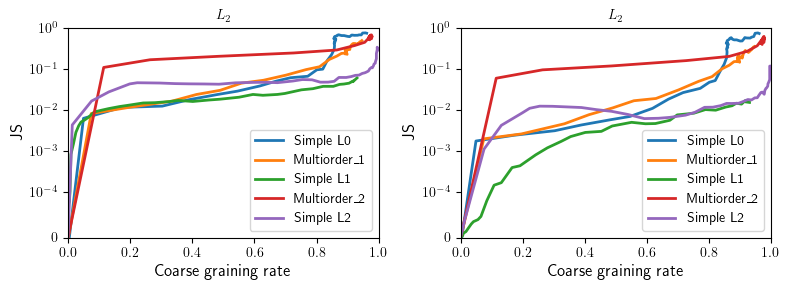

In [120]:

topp = [1,1]
logg = True
fig, axv = plt.subplots(1,d,figsize = (4*d,3))

for norml in range(d+1):
    for degg in range(d):
        ax1 = axv[degg]
        #ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Coarse graining rate')
        ax1.set_ylabel(measure.__name__)
        ax1.set_ylim(bottom = 0 ,top = topp[degg])
        ax1.set_xlim(0,1)
        if logg:
            #ax1.set_yscale('log')
            ax1.set_yscale('symlog',linthresh=0.0001)
        ax1.plot(1-np.median(Ns_simple[:,norml,:]/Nsimp,0), np.median(deg_distance_simple[:,norml,degg,:],0), lw = 2, label = f"Simple L{norml}")
        if norml < d:
            ax1.plot(1-np.median(Ns_multi[:,norml,:]/Nrand,0), np.median(deg_distance_multi[:,norml,degg,:],0), lw = 2, label = f"Multiorder_{norml+1}")
        ax1.legend()
        ax1.set_title(f"$L_{norml}$")
fig.tight_layout()  # otherwise the right y-label is slightly clipped


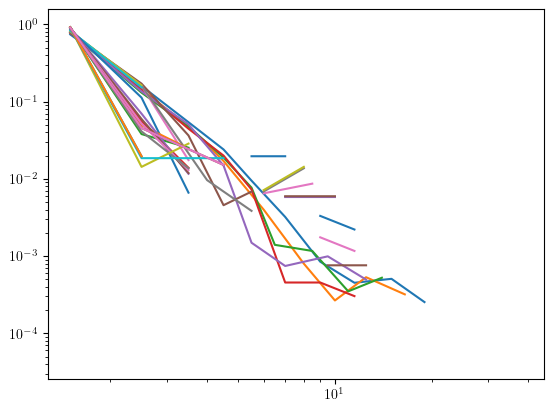

In [118]:
for tau in range(50):
    pwl.plot_pdf(deg_dist_multi[0][tau][1][1][deg_dist_multi[0][tau][1][1] != 0])

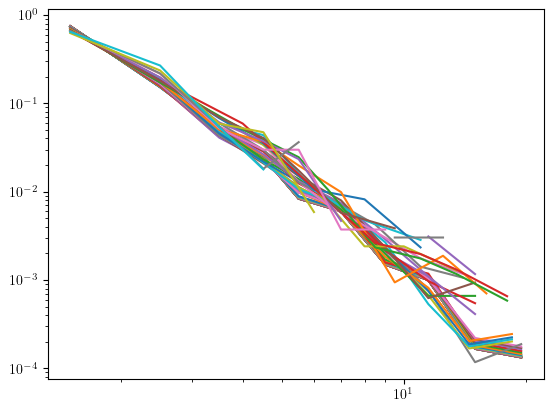

In [116]:
for tau in range(50):
    pwl.plot_pdf(deg_dist_simple[0][tau][1][1][deg_dist_simple[0][tau][1][1] != 0])